### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/df_features.gz')

### Create Predicted Category for final models (2 categories)

In [3]:
# Creo estasdisticos por hotel para introducir en el modelo, ya que cada hotel se comporta de manera distina
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [4]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [5]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df)

Good    0.831599
Bad     0.168401
Name: Category, dtype: float64

### Process Data Frame to Model

In [6]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','Price','Reservation_ADR','count', 'mean', 
               'std', 'min', '25%', '50%', '75%', 'max']

x_col = x_categorical + x_numerical
y_col = 'Category'

In [7]:
X_numerical = df[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [8]:
df['Review_Month'] = df['Review_Month'].astype(str)
X_categorical = pd.get_dummies(df[x_categorical], prefix_sep='_', drop_first=False)
X_categorical = X_categorical.fillna('Not Available')

In [9]:
X = pd.concat([X_numerical_std, X_categorical, df['Nationality_Recode']], axis=1, sort=False)
y = df[y_col]

In [10]:
X = X[['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'mean','std', 'max', 'Review_Month_1', 
       'Review_Month_10', 'Review_Month_2','Review_Month_3', 'Review_Month_4', 'Review_Month_7', 'Review_Month_8',
       'Review_Month_9', 'City_Amsterdam', 'City_London', 'Pet_With a pet','Purpose_Leisure trip', 
       'Whom_Family with older children','Whom_Family with young children', 'Whom_Travelers with friends',
       'Room_Recode_Deluxe', 'Room_Recode_Other (Standard)','Room_Recode_Studio', 'Nationality_Recode_Arab States',
       'Nationality_Recode_Asia & Pacific','Nationality_Recode_Eastern Europe', 'Nationality_Recode_Middle east',
       'Nationality_Recode_North America', 'Nationality_Recode_Oceania','Nationality_Recode_UK & Ireland', 
       'Nationality_Recode_Western Europe','Length_Recode_Stayed 2 nights', 'Length_Recode_Stayed 5 nights',
       'Length_Recode_Stayed 6 nights', 'Length_Recode_Stayed 7 nights','Length_Recode_Stayed 8 nights', 'Stars_Pension',
       'Stars_hotel de 3 estrellas','Nationality_Recode']]

In [11]:
df_model = pd.concat([y, X], axis=1, sort=False)

In [12]:
pickle.dump(df_model, open('./sav/df_model.sav', 'wb'))

### Balance Nationalities and / or Categories

In [13]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [14]:
df_balanced_1 = balance_df(df_model, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*1.5))

In [15]:
df_balanced_2.Nationality_Recode.value_counts()

North America          11829
UK & Ireland           11810
Western Europe         11809
Middle east            11761
Eastern Europe          9058
Asia & Pacific          7869
Oceania                 7555
Sub-Saharian Africa     2023
South/Latin America     1614
China                   1127
Arab States              815
Name: Nationality_Recode, dtype: int64

In [16]:
pickle.dump(df_balanced_2, open('./sav/df_balanced.sav', 'wb'))

### Subset Data Frame to Model

In [17]:
df_subset = df_balanced_2.sample(n=10000, random_state=1)

In [18]:
pickle.dump(df_subset, open('./sav/df_subset.sav', 'wb'))

In [19]:
y = df_subset['Category']
X = df_subset[df_subset.columns[1:-1]]

Split into Train and Test

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [21]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((2000, 38), (2000,), (8000, 38), (8000,))

## MODELS

### Functions

In [22]:
import time
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score, make_scorer
from collections import Counter
from sklearn.neighbors import KDTree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials, space_eval
from catboost import CatBoostClassifier
import xgboost as xgb

In [23]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [24]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [25]:
def print_result(clf, X_train, X_test, y_train, y_test):
    print('Accuracy Test :', f'{accuracy_score(clf.predict(X_test), y_test):.4f}', 
          '| F1 Test :', f'{f1_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}',
          '| Precision Test :', f'{precision_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}', 
          '| Recall Test :', f'{recall_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}', 
          '| H Test :', f'{H_score(clf.predict(X_test), y_test):.4f}')
    
    print('Accuracy Train:', f'{accuracy_score(clf.predict(X_train), y_train):.4f}', 
          '| F1 Train:', f'{f1_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}',
          '| Precision Train:', f'{precision_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}', 
          '| Recall Train:', f'{recall_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}', 
          '| H Train:', f'{H_score(clf.predict(X_train), y_train):.4f}')

In [26]:
def H_score(X_train, y_train):
    acc = accuracy_score(X_train, y_train)
    f1 = f1_score(X_train, y_train, pos_label = "Bad")
    return(2 / ((1/(acc+0.0000001))+(1/(f1+0.0000001))))

In [27]:
def bayesian(space, X, y, modelo, nevals):
    
    def objective(space):        
        global best_score
        model = modelo(**space, random_state = 1)   
        cv =  StratifiedKFold(n_splits = 5, random_state = 1)
        score = -cross_val_score(model, X, y, cv = cv, scoring = 'accuracy', verbose = False).mean()
        if (score < best_score):
            best_score = score
        return score

    start = time.time()
    rstate = np.random.RandomState(1)
    best = fmin(objective, space = space,algo = tpe.suggest, max_evals = nevals, trials = Trials(), rstate = rstate)

    print("Hyperopt search took %.2f seconds" % ((time.time() - start)))
    print("Best score: %.4f " % (-best_score))
    print("Best space: ", space_eval(params, best))
    return(space_eval(params, best))

### KNN (KDTree Implementation)

In [28]:
tree = KDTree(X_train)

In [29]:
acc_knn = []

In [30]:
for k in range(1, 150):
    nearest_dist, nearest_ind = tree.query(X_test, k = k)
    pred = [Counter([y_train.iloc[k] for k in x]).most_common(1)[0][0] for x in nearest_ind]
    acc_knn.append(accuracy_score(pred, y_test))
    print(k, '-', f'{accuracy_score(pred, y_test):.4f}', end='\r', flush=True)

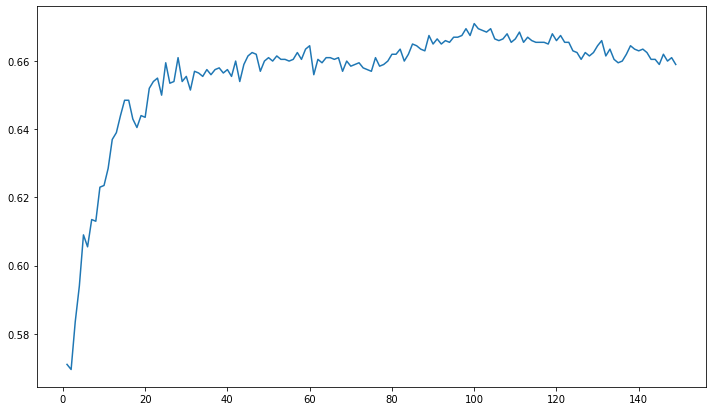

In [31]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(range(1,150), acc_knn)

In [32]:
max(acc_knn), np.argmax(acc_knn)

(0.671, 99)

In [33]:
nearest_dist, nearest_ind = tree.query(X_test, k = (np.argmax(acc_knn)+1))

In [34]:
pred_knn = [Counter([y_train.iloc[k] for k in x]).most_common(1)[0][0] for x in nearest_ind]

In [35]:
print('Accuracy Test :', f'{accuracy_score(pred_knn, y_test):.4f}', 
      '| F1 Test :', f'{f1_score(pred_knn, y_test, pos_label="Bad"):.4f}',
      '| Precision Test :', f'{precision_score(pred_knn, y_test, pos_label="Bad"):.4f}', 
      '| Recall Test :', f'{recall_score(pred_knn, y_test, pos_label="Bad"):.4f}', 
      '| H Test :', f'{H_score(pred_knn, y_test):.4f}')

Accuracy Test : 0.6710 | F1 Test : 0.6670 | Precision Test : 0.6590 | Recall Test : 0.6752 | H Test : 0.6690


### Gradient Boosted Trees

In [36]:
params = {'learning_rate':     hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 
                                                          0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.50, 0.75, 1]), 
          'n_estimators':      hp.choice('n_estimators', range(1,400)),
          'max_depth':         hp.choice('max_depth',range(1,20)),
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 10, endpoint=True)),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'subsample':         hp.choice('subsample',[1]), 
          'max_features':      hp.choice('max_features',['sqrt'])}

best_score = 1
gbt_params = bayesian(params, X_train, y_train, GradientBoostingClassifier, 50)
pred_gbt = evaluate_model(GradientBoostingClassifier(**gbt_params, random_state=1), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:56<00:00,  4.74s/trial, best loss: -0.6615]
Hyperopt search took 237.22 seconds
Best score: 0.6615 
Best space:  {'learning_rate': 0.025, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 0.06999999999999999, 'min_samples_split': 0.01, 'n_estimators': 145, 'subsample': 1}
Accuracy Test : 0.6700 | F1 Test : 0.6673 | Precision Test : 0.6620 | Recall Test : 0.6728 | H Test : 0.6687
Accuracy Train: 0.6685 | F1 Train: 0.6702 | Precision Train: 0.6741 | Recall Train: 0.6664 | H Train: 0.6694


### Random Forest

In [37]:
params = {'bootstrap':         hp.choice('bootstrap',[True, False]),
          'max_depth':         hp.choice('max_depth', range(1, 20)),
          'max_features':      hp.choice('max_features',['auto', 'sqrt']),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'n_estimators':      hp.choice('n_estimators',range(1,400))}

best_score = 1
rf_params = bayesian(params, X_train, y_train, RandomForestClassifier, 50)
pred_rf = evaluate_model(RandomForestClassifier(**rf_params, random_state=1), X_train, X_test, y_train, y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:11<00:00,  6.23s/trial, best loss: -0.655625]
Hyperopt search took 311.98 seconds
Best score: 0.6556 
Best space:  {'bootstrap': True, 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 0.04, 'min_samples_split': 0.04, 'n_estimators': 190}
Accuracy Test : 0.6610 | F1 Test : 0.6647 | Precision Test : 0.6720 | Recall Test : 0.6575 | H Test : 0.6628
Accuracy Train: 0.6599 | F1 Train: 0.6663 | Precision Train: 0.6796 | Recall Train: 0.6536 | H Train: 0.6631


### XGBoosting

In [38]:
params = {'learning_rate':    hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                                         0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75]), 
          'max_depth':        hp.choice('max_depth',range(1,20)),
          'min_child_weight': hp.choice('min_child_weight',np.linspace(0.01, 1.0, 100, endpoint=True)),
          'gamma':            hp.choice('gamma',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'colsample_bytree': hp.choice('colsample_bytree',np.linspace(0.0, 1, 101, endpoint=True)), 
          'n_estimators':     hp.choice('n_estimators', range(1,200))}

best_score = 1
xgb_params = bayesian(params, X_train, y_train, xgb.XGBClassifier, 50)
pred_xgb = evaluate_model(xgb.XGBClassifier(**xgb_params, random_state=1), X_train, X_test, y_train, y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [11:25<00:00, 13.71s/trial, best loss: -0.662625]
Hyperopt search took 685.50 seconds
Best score: 0.6626 
Best space:  {'colsample_bytree': 0.53, 'gamma': 0.44, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0.09, 'n_estimators': 188}
Accuracy Test : 0.6700 | F1 Test : 0.6677 | Precision Test : 0.6630 | Recall Test : 0.6724 | H Test : 0.6688
Accuracy Train: 0.6807 | F1 Train: 0.6828 | Precision Train: 0.6876 | Recall Train: 0.6781 | H Train: 0.6818


### Logistic Regresion

In [39]:
params = {"C":   hp.choice('C',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]),
          ""
          "tol": hp.choice('tol',[0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 
                                  0.05, 0.1])}

best_score = 1
log_params = bayesian(params, X_train, y_train, LogisticRegression, 50)
pred_log = evaluate_model(LogisticRegression(**log_params, max_iter = 1000, random_state=1), X_train, X_test, y_train, y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.93trial/s, best loss: -0.665375]
Hyperopt search took 25.91 seconds
Best score: 0.6654 
Best space:  {'C': 0.1, 'tol': 0.1}
Accuracy Test : 0.6660 | F1 Test : 0.6599 | Precision Test : 0.6480 | Recall Test : 0.6722 | H Test : 0.6629
Accuracy Train: 0.6719 | F1 Train: 0.6706 | Precision Train: 0.6683 | Recall Train: 0.6729 | H Train: 0.6712


### Decision Trees

In [40]:
params = {"max_depth":        hp.choice('max_depth', range(1, 50)),
          "max_features":     hp.choice('max_features', range(1, 50)),
          "min_samples_leaf": hp.choice('min_samples_leaf', range(1, 200)),
          "criterion":        hp.choice('criterion', ["gini", "entropy"])}

best_score = 1
tree_params = bayesian(params, X_train, y_train, DecisionTreeClassifier, 50)
pred_tree = evaluate_model(DecisionTreeClassifier(**tree_params, random_state=1), X_train, X_test, y_train, y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.49trial/s, best loss: -0.650125]
Hyperopt search took 20.22 seconds
Best score: 0.6501 
Best space:  {'criterion': 'gini', 'max_depth': 27, 'max_features': 13, 'min_samples_leaf': 115}
Accuracy Test : 0.6500 | F1 Test : 0.6503 | Precision Test : 0.6510 | Recall Test : 0.6497 | H Test : 0.6502
Accuracy Train: 0.6646 | F1 Train: 0.6677 | Precision Train: 0.6743 | Recall Train: 0.6613 | H Train: 0.6662


### SVM (poly)

In [41]:
params = {"degree": hp.choice('degree', [2, 3, 4]),
          "kernel": hp.choice('kernel', ['poly']), 
          "C":      hp.choice('C', [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                    0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75])}
best_score = 1
svm_params = bayesian(params, X_train, y_train, SVC, 10)
pred_svm = evaluate_model(SVC(**svm_params, random_state=1), X_train, X_test, y_train, y_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:18<00:00, 37.80s/trial, best loss: -0.659]
Hyperopt search took 378.07 seconds
Best score: 0.6590 
Best space:  {'C': 0.1, 'degree': 2, 'kernel': 'poly'}
Accuracy Test : 0.6670 | F1 Test : 0.6804 | Precision Test : 0.7090 | Recall Test : 0.6541 | H Test : 0.6736
Accuracy Train: 0.6705 | F1 Train: 0.6875 | Precision Train: 0.7251 | Recall Train: 0.6535 | H Train: 0.6789


### SVM (rbf)

In [42]:
params = {'C':      hp.choice('C', [1, 2, 5, 10, 15, 20]), 
          'gamma':  hp.choice('gamma', [0.0001, 0.001, 0.01, 0.1]),
          'kernel': hp.choice('kernel', ['rbf'])}

best_score = 1
svm_params_2 = bayesian(params, X_train, y_train, SVC, 10)
pred_svm_2 = evaluate_model(SVC(**svm_params_2, random_state=1), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:46<00:00, 46.70s/trial, best loss: -0.6665000000000001]
Hyperopt search took 467.02 seconds
Best score: 0.6665 
Best space:  {'C': 15, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy Test : 0.6685 | F1 Test : 0.6690 | Precision Test : 0.6700 | Recall Test : 0.6680 | H Test : 0.6687
Accuracy Train: 0.6705 | F1 Train: 0.6738 | Precision Train: 0.6811 | Recall Train: 0.6667 | H Train: 0.6722


### CatBoost

In [43]:
cat_features = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]
params = {'iterations':        hp.choice('iterations', range(100, 4000, 25)), 
          'learning_rate':     hp.choice('learning_rate', [0.001, 0.0025, 0.0075, 0.01, 0.025, 0.05, 0.1]),
          'l2_leaf_reg':       hp.choice('l2_leaf_reg', range(1, 10)), 
          'cat_features':      hp.choice('cat_features', [cat_features]), 
          'verbose':           hp.choice('verbose', [False])}

best_score = 1
cat_params = bayesian(params, X_train, y_train, CatBoostClassifier, 10)
pred_cat = evaluate_model(CatBoostClassifier(**cat_params, random_state=1), X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:46<00:00, 70.67s/trial, best loss: -0.66475]
Hyperopt search took 706.83 seconds
Best score: 0.6647 
Best space:  {'cat_features': (5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37), 'iterations': 1825, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'verbose': False}
Accuracy Test : 0.6705 | F1 Test : 0.6667 | Precision Test : 0.6590 | Recall Test : 0.6745 | H Test : 0.6686
Accuracy Train: 0.7400 | F1 Train: 0.7420 | Precision Train: 0.7481 | Recall Train: 0.7360 | H Train: 0.7410


### Best Model (KNN)

In [44]:
pd.crosstab(np.array(pred_knn), y_test)

Category,Bad,Good
row_0,,
Bad,659,317
Good,341,683


### Save Models

In [45]:
models = (tree,
          LogisticRegression(**log_params, max_iter = 1000).fit(X_train, y_train),
          SVC(**svm_params).fit(X_train, y_train),
          SVC(**svm_params_2).fit(X_train, y_train),
          DecisionTreeClassifier(**tree_params).fit(X_train, y_train),
          RandomForestClassifier(**rf_params).fit(X_train, y_train),
          GradientBoostingClassifier(**gbt_params).fit(X_train, y_train),
          xgb.XGBClassifier(**xgb_params).fit(X_train, y_train),
          CatBoostClassifier(**cat_params).fit(X_train, y_train)
)

In [46]:
pickle.dump(models, open('./sav/model_accuracy.sav', 'wb'))